# Extract bubble from simulations

In [1]:
import numpy as np
import scipy as scp
from scipy import optimize
import matplotlib.pyplot as plt

### Simulation Parameters 

In [1]:
nLat = 4096
nSims = 100
minSim = 100
simstep = 1

nu = 2.*10**(-3)
lamb = 6.; print('lamb = ', lamb)
m2eff = 4. * nu * (- 1. + lamb**2); print('m2eff = ', m2eff)
lenLat = 2 * 50. / np.sqrt(2. * nu); print('lenLat = ', lenLat)
phi0 = 2. * np.pi / 7.; print('phi0 = ', phi0)

alpha = 8.
nCols = 1
phi_initial = np.pi
dt_phi_initial = 0.

############################################################
nyq = nLat//2+1
spec = nyq
hLat = nLat//2
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha
light_cone = dtout/dx

lamb =  6.0
m2eff =  0.28


NameError: name 'np' is not defined

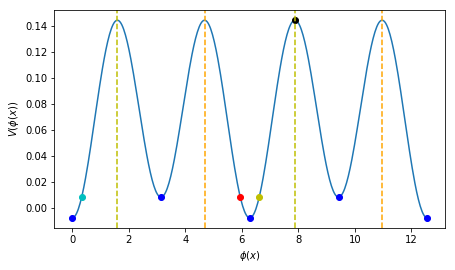

In [ ]:
def V(phi):
    return ( -np.cos(phi) + 0.5 * lamb**2 * np.sin(phi)**2 ) * 4 * nu
def dV(phi):
    return ( np.sin(phi) + 0.5 * lamb**2 * np.sin(2*phi) ) * 4 * nu

right_phi_at_V_max = optimize.minimize_scalar(lambda x: -V(x), bounds=[np.pi, 2*np.pi], method='bounded')
left_phi_at_V_max = optimize.minimize_scalar(lambda x: -V(x), bounds=[0, np.pi], method='bounded')
right_left_phi_at_V_max = optimize.minimize_scalar(lambda x: -V(x), bounds=[2*np.pi, 3*np.pi], method='bounded')

def F(x):
    return V(x) - V(phi_initial)
phi_upper_bound = optimize.fsolve(F, 5.5)[0]
phi_lower_bound = optimize.fsolve(F, 0.5)[0]
phi_upper_lower_bound = optimize.fsolve(F, 7)[0]

fig = plt.figure(figsize=(7, 4))
plt.plot([i for i in np.arange(0, 4*phi_initial, phi_initial/100)], [V(i) for i in np.arange(0, 4*phi_initial, phi_initial/100)])
plt.plot(phi_upper_bound, V(phi_upper_bound), 'ro')
plt.plot(phi_lower_bound, V(phi_lower_bound), 'co')
plt.plot(phi_upper_lower_bound, V(phi_upper_lower_bound), 'yo')

plt.plot(right_left_phi_at_V_max.x, V(right_left_phi_at_V_max.x), 'ko')
[plt.plot(i*phi_initial, V(i*phi_initial), 'bo') for i in range(5)]
[plt.axvline(left_phi_at_V_max.x + i*phi_initial, color='y', ls='--') for i in range(0,3,2)]
[plt.axvline(right_phi_at_V_max.x + i*phi_initial, color='orange', ls='--') for i in range(0,3,2)]
plt.xlabel(r'$\phi(x)$'); plt.ylabel(r'$V(\phi(x))$'); plt.show()

### Extract data from files

In [ ]:
suffix = '_for_phi0{:.4f}'.format(phi0)+'_lambda{:.4f}'.format(lamb)+'_len{:.4f}'.format(lenLat)+'_x'+str(nLat)

def bubbles_file(sim):
#    return pickle_location+'bubbles_from_sim'+str(min)+'_up_to_sim'+str(max-1)+suffix+'.npy'
    return '/gpfs/dpirvu/oscillons/bubble_sim'+str(sim)+suffix+'.npy'

def sim_location(sim):
    return '/gpfs/dpirvu/sims/x'+str(nLat)+'_phi0{:.4f}'.format(phi0)+'_lambda{:.4f}'.format(lamb)+'_sim'+str(sim)+'_fields.dat'

def extract_data(filename, col):
    print(filename)
    infile = open(filename,'r')
    lines = infile.readlines()
    field_values = [float(line.split()[col]) for line in lines[3:]]
    infile.close()
    return field_values

def check_decay(simulation):
    right_phi = sum([1 for x in simulation[-1] if x > np.floor(phi_upper_bound)])
    left_phi = sum([1 for x in simulation[-1] if x < np.ceil(phi_lower_bound)])
    if right_phi > nLat*0.3 and left_phi < nLat*0.05: return 0
    elif left_phi > nLat*0.3 and right_phi < nLat*0.05: return 1
    else: return 2

def time_at_fraction(bubble, frac, limit):
    T, N = len(bubble), len(bubble[0])
    right_phi_x = [np.sum([1 for x in slice if x >= limit]) for slice in bubble]
    time_list = [t if (right_phi_x[t] <= N*frac) else 0 for t in range(T)]
    return next((t for t in time_list[::-1] if t != 0), 0)

def triage(sim):
    y = extract_data(sim_location(sim), 0)
    nT = len(y)//nLat
    ttotmin = 5000
    if nT > ttotmin:
        outcome = check_decay(np.reshape(y, (nT, nLat)))
        if outcome != 2:
            data = [extract_data(sim_location(sim), col) for col in range(nCols)]
            try:
                data = [np.reshape(data[col], (nT, nLat)) for col in range(nCols)]
            except ValueError:
                return None
            if outcome == 1:
                data[0] = [2*phi_initial - i for i in data[0]]
#                data[1] = [-j for j in data[1]]
            tdecap = time_at_fraction(data[0], 0.01, right_left_phi_at_V_max.x)
#            if tdecap < 0: tdecap = 0
            data = [data[i][:tdecap] for i in range(len(data))]
            print('sim', sim, ', duration ', nT)
            return data, sim

def alldata():
    all_rsp_data = []
    for sim in range(minSim, nSims, simstep):
        if sim == nSims // 2:
            print('Halfway through.')
        a = triage(sim)
        if a is not None:
            data, sim = a
            all_rsp_data.append(data)
            plot_real_space_data(data, 0)
            np.save(bubbles_file(sim), data)
    return

def plot_real_space_data(sim, col):
    fig, ax = plt.subplots(1, 1, figsize = (7, 5))
#    im = ax.imshow(all_data[sim][col], aspect='auto', interpolation='none', origin='lower')
    im = ax.imshow(sim[col], aspect='auto', interpolation='none', origin='lower', extent=[0, np.sqrt(4*nu)*len(sim[0][0])*dx, 0, np.sqrt(4*nu)*len(sim[0])*dtout])
    clb = plt.colorbar(im, ax = ax)
    clb.set_label(r'$\phi(t, r)$', labelpad=-28, y=1.08, rotation=0)
    ax.set(xlabel = r'$\phi_0^{-1} \sqrt{V_0} r$', ylabel = r'$\phi_0^{-1} \sqrt{V_0} t$')
    plt.show()
    return

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim36_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim37_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim38_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim38_fields.dat
sim 38 , duration  31617


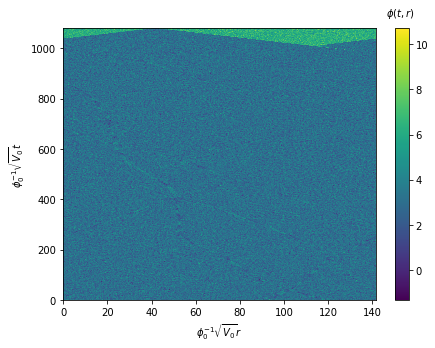

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim39_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim39_fields.dat
sim 39 , duration  9856


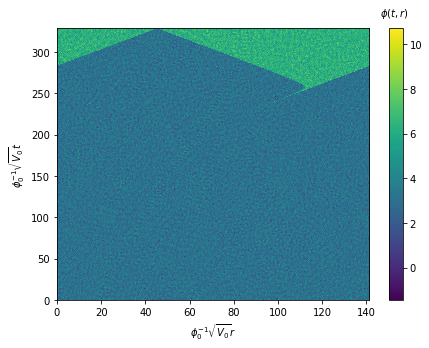

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim40_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim40_fields.dat
sim 40 , duration  6661


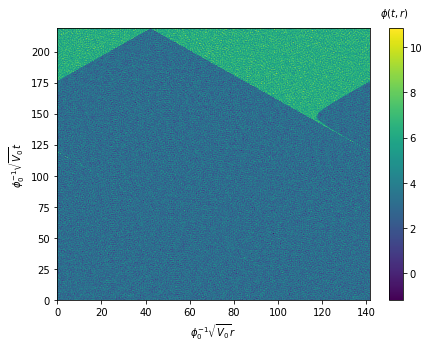

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim41_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim41_fields.dat
sim 41 , duration  7260


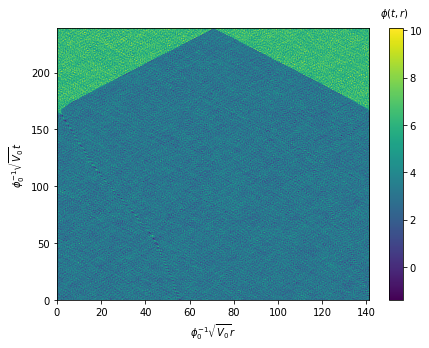

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim42_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim43_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim44_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim45_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim46_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim47_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim48_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim48_fields.dat
sim 48 , duration  18191


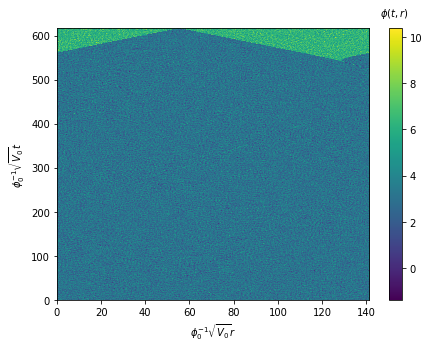

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim49_fields.dat
Halfway through.
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim50_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim50_fields.dat
sim 50 , duration  27731


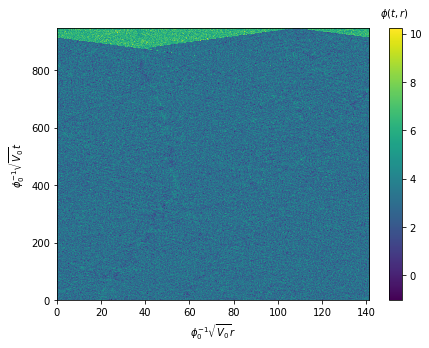

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim51_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim52_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim53_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim54_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim55_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim56_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim56_fields.dat
sim 56 , duration  7860


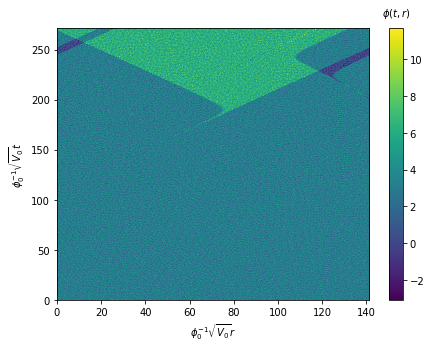

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim57_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim58_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim58_fields.dat
sim 58 , duration  7440


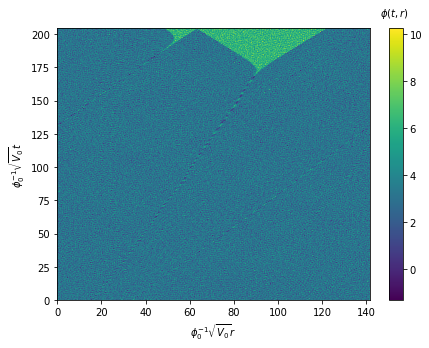

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim59_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim60_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim61_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim62_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim62_fields.dat
sim 62 , duration  24581


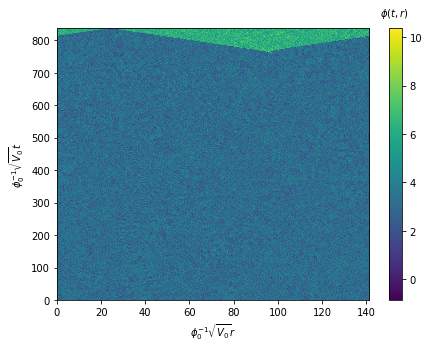

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim63_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim64_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim65_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim66_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim66_fields.dat
sim 66 , duration  5981


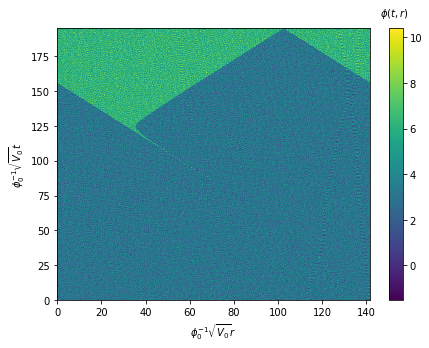

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim67_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim67_fields.dat
sim 67 , duration  9432


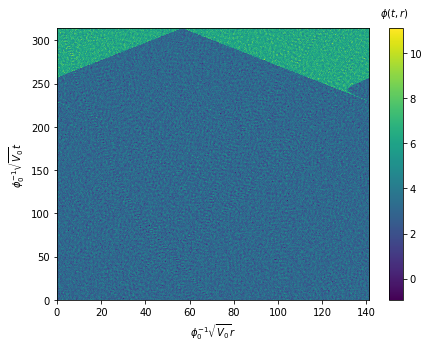

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim68_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim68_fields.dat
sim 68 , duration  12287


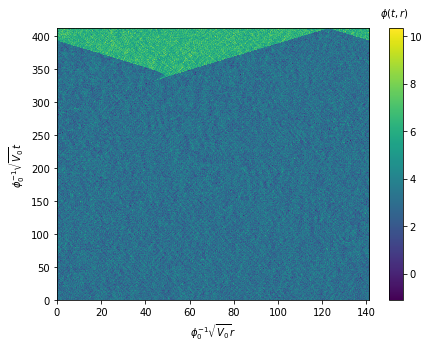

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim69_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim69_fields.dat
sim 69 , duration  18541


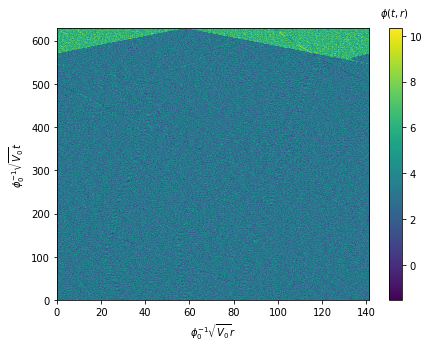

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim70_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim70_fields.dat
sim 70 , duration  7865


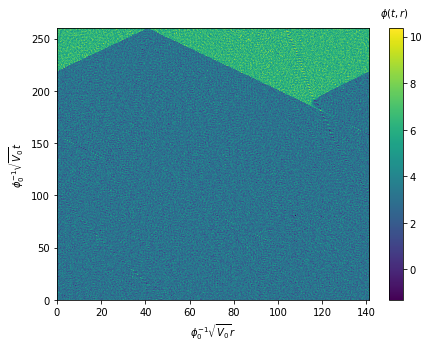

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim71_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim71_fields.dat
sim 71 , duration  10972


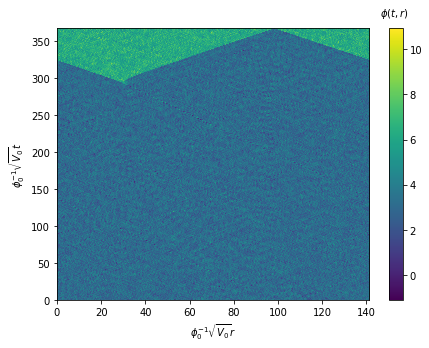

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim72_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim73_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim74_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim75_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim76_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim76_fields.dat
sim 76 , duration  6037


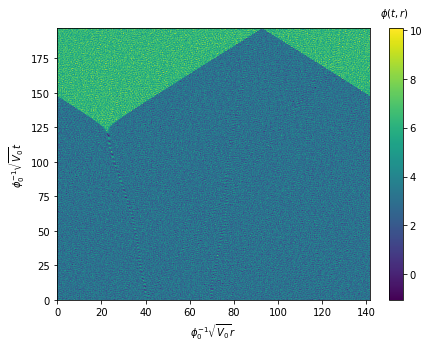

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim77_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim78_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim79_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim80_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim80_fields.dat
sim 80 , duration  10993


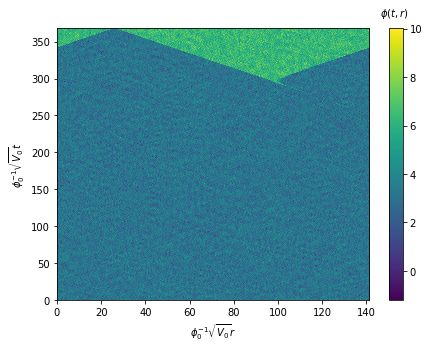

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim81_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim81_fields.dat
sim 81 , duration  26258


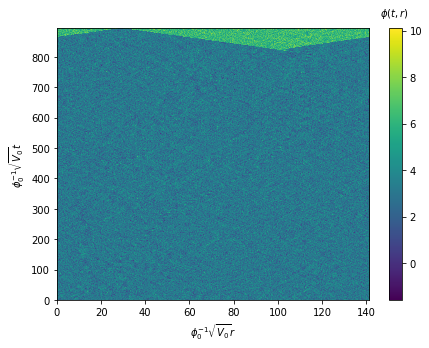

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim82_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim83_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim83_fields.dat
sim 83 , duration  9249


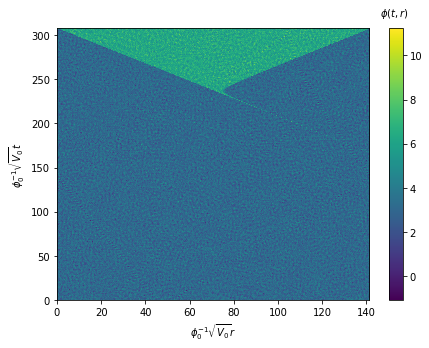

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim84_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim84_fields.dat
sim 84 , duration  28098


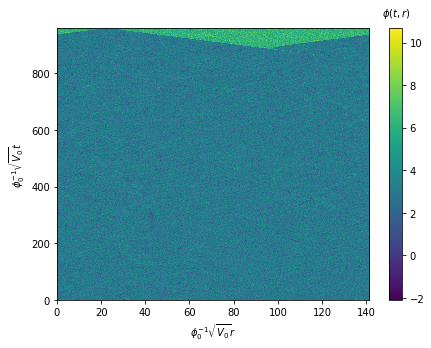

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim85_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim85_fields.dat
sim 85 , duration  26490


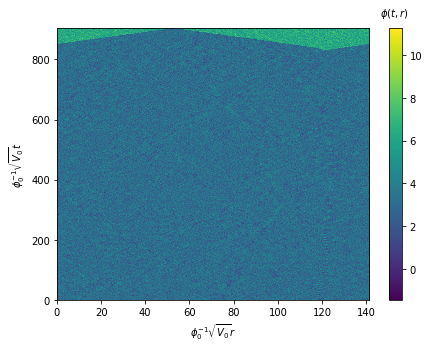

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim86_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim86_fields.dat
sim 86 , duration  15661


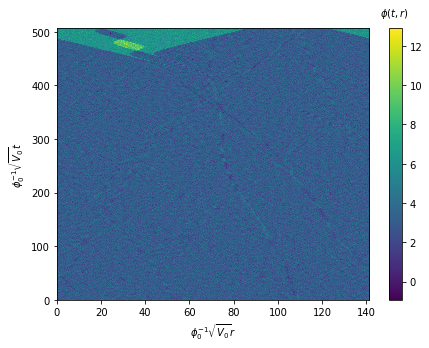

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim87_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim87_fields.dat
sim 87 , duration  9766


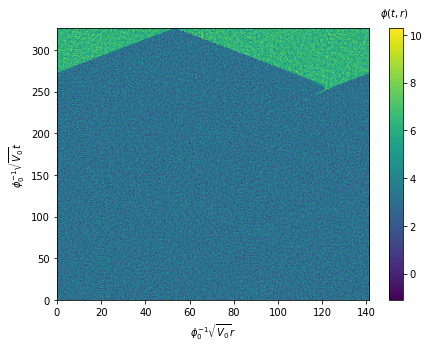

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim88_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim89_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim90_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim90_fields.dat
sim 90 , duration  20250


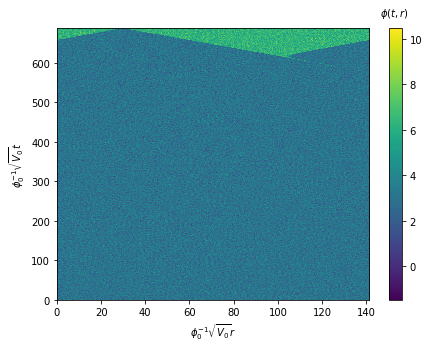

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim91_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim92_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim93_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim94_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim95_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim95_fields.dat
sim 95 , duration  6135


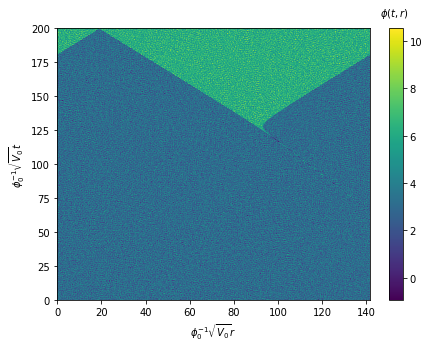

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim96_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim97_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim98_fields.dat
/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim98_fields.dat
sim 98 , duration  5010


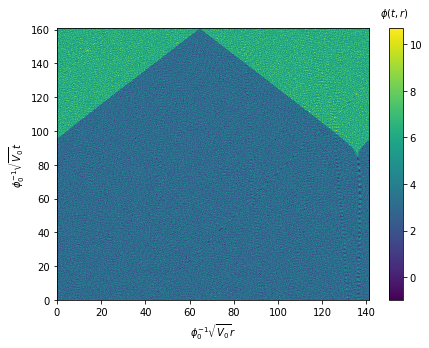

/gpfs/dpirvu/sims/x4096_phi00.8976_lambda6.0000_sim99_fields.dat


In [ ]:
alldata()